In [125]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 20)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

import math
import scipy.stats as ss

In [126]:
#Reading Files
path = "/Users/larst/OneDrive/Documents/GitHub/KaggleS3E21/data/"
data = pd.read_csv(path+"sample_submission.csv")
outliers = pd.read_csv(path+"outliers.csv")

In [127]:
outliers

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,9.265,0,0,0,0.180,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,8.21,3.710,5.420,0,9.265,0,0,0,0.020,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
2,0,8.39,8.700,8.100,0,9.200,0,0,0,0.280,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
3,0,8.07,8.050,8.650,0,9.265,0,0,0,0.360,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
4,0,8.12,9.000,9.000,0,9.115,0,0,0,0.240,0,0,0,0,0.280,0,0,0.060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,0,8.65,8.367,8.760,0,9.265,0,0,0,0.720,0,0,0,0,0.280,0,0,0.040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2973,0,8.08,6.250,8.300,0,9.265,0,0,0,0.565,0,0,0,0,0.429,0,0,0.052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.695,0,0
2974,0,8.09,6.630,6.630,0,7.600,0,0,0,1.300,0,0,0,0,1.285,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2975,0,9.95,8.367,8.433,0,6.170,0,0,0,0.430,0,0,0,0,0.310,0,0,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0


In [128]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

In [129]:
X, y = data.drop('target', axis = 1), data.target

scores = cross_val_score(rf, 
                         X, 
                         y,
                         cv = 10, 
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1)

print(f'RMSE Mean (BASELINE): {scores.mean()}, Standard Deviation: {scores.std()}')


RMSE Mean (BASELINE): -1.3770624373999154, Standard Deviation: 0.6399666156079411


In [130]:
#clipping
data.target = data.target.clip(lower = 7, upper = 20)

In [131]:
def preprocess_outliers(data):
    svm = SGDOneClassSVM(nu=0.55)
    yhat = svm.fit_predict(data.drop('id', axis=1))
    mask = yhat != -1
    data_SVM = data.loc[mask, :].reset_index(drop=True)
   

    iso = IsolationForest(random_state=0)
    yhat = iso.fit_predict(data_SVM.drop('id', axis=1))
    mask = yhat != -1
    data_ISO = data_SVM.loc[mask, :].reset_index(drop=True)


    lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
    yhat = lof.fit_predict(data_ISO.drop(['id', 'target'], axis=1))
    mask = yhat != -1
    data_final = data_ISO.loc[mask, :].reset_index(drop=True)
  

    return data_final

In [132]:
selected_features = [
    'O2_1', 
    'O2_2',
    'BOD5_5'
    ,'NO2_2'
    ,'O2_4'
    ,'NH4_6'
    ,'NH4_1'
    #,'NH4_5'
    #,'O2_7'
    #,'O2_6'
]

In [133]:
scores = np.array(-1)

In [134]:
while (scores.mean()<-0.875):
    data = pd.read_csv(path+"sample_submission.csv")
    data.target = data.target.clip(lower = 7, upper = 20)
    data_final = preprocess_outliers(data)
    X_final, y_final = data_final.drop('target', axis = 1), data_final.target

    # kf = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
    scores = cross_val_score(rf, 
                             X_final[selected_features],
                             y_final,
                             cv = 10, 
                             scoring = 'neg_root_mean_squared_error',
                             n_jobs = -1)

    print(f'[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9256022243080233, Standard Deviation: 0.09972327495218938
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9157371159498184, Standard Deviation: 0.0780800804870206
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9160700791298891, Standard Deviation: 0.0786455500660949
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9384466539563066, Standard Deviation: 0.08582399273357917
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9182388082619862, Standard Deviation: 0.08383698251423063
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9070750220950622, Standard Deviation: 0.07735123810521083
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9078145100742014, Standard Deviation: 0.0827233164118608
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8828230868383067, Standard Deviation: 0.08155848514720618
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9149838996422679, Standard Deviation: 0.07841915316953231
[ENSEMBLE + FS + CLIPPING_7_20]

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9256022243080233, Standard Deviation: 0.09972327495218938
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9182388082619862, Standard Deviation: 0.08383698251423059
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9182388082619862, Standard Deviation: 0.08383698251423065
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.914692461497809, Standard Deviation: 0.101465488504428
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9146924614978091, Standard Deviation: 0.10146548850442803
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9182388082619862, Standard Deviation: 0.08383698251423057
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9317771265835402, Standard Deviation: 0.0918760638623104
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.909455228515271, Standard Deviation: 0.08876088274322798
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9182388082619864, Standard Deviation: 0.08383698251423066
[ENSEMBLE + FS + CLIPPING_7_20] -

KeyboardInterrupt: 

In [106]:
def remove_bad_labels(data, bad_labels):
    data_final = data[~data['id'].isin(bad_labels)]
    return data_final

In [107]:
def set_unused_features_to_zero(data, selected_features,X):
    for column in X.columns:
        if column not in selected_features:
            data[column] = 0
    return data

In [110]:
data_without_outliers = data_final.copy()
data_without_outliers.to_csv('data_without_outliers.csv', index = False)

In [111]:
bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]

In [112]:
data_final_no_bad_labels = remove_bad_labels(data_final,bad_labels)

In [113]:
data_final_processed = set_unused_features_to_zero(data_final_no_bad_labels, selected_features,X)

C:\Users\larst\AppData\Local\Temp\ipykernel_51780\1379245579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = 0


In [114]:
data_final_processed

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,9.265,0,0,0,0.180,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,8.21,3.710,5.420,0,9.265,0,0,0,0.020,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
2,0,8.39,8.700,8.100,0,9.200,0,0,0,0.280,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
3,0,8.07,8.050,8.650,0,9.265,0,0,0,0.360,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
4,0,8.12,9.000,9.000,0,9.115,0,0,0,0.240,0,0,0,0,0.280,0,0,0.060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,0,8.65,8.367,8.760,0,9.265,0,0,0,0.720,0,0,0,0,0.280,0,0,0.040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2870,0,8.08,6.250,8.300,0,9.265,0,0,0,0.565,0,0,0,0,0.429,0,0,0.052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.695,0,0
2871,0,8.09,6.630,6.630,0,7.600,0,0,0,1.300,0,0,0,0,1.285,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2872,0,9.95,8.367,8.433,0,6.170,0,0,0,0.430,0,0,0,0,0.310,0,0,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0


In [115]:
submission = data_final_processed.reset_index(drop = True).copy()

submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.50,9.00,0,9.265,0,0,0,0.18,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,8.21,3.71,5.42,0,9.265,0,0,0,0.02,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
2,0,8.39,8.70,8.10,0,9.200,0,0,0,0.28,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
3,0,8.07,8.05,8.65,0,9.265,0,0,0,0.36,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
4,0,8.12,9.00,9.00,0,9.115,0,0,0,0.24,0,0,0,0,0.280,0,0,0.060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0


In [116]:
submission.to_csv('submission.csv', index = False)

Text(0.5, 1.0, 'target distribution')

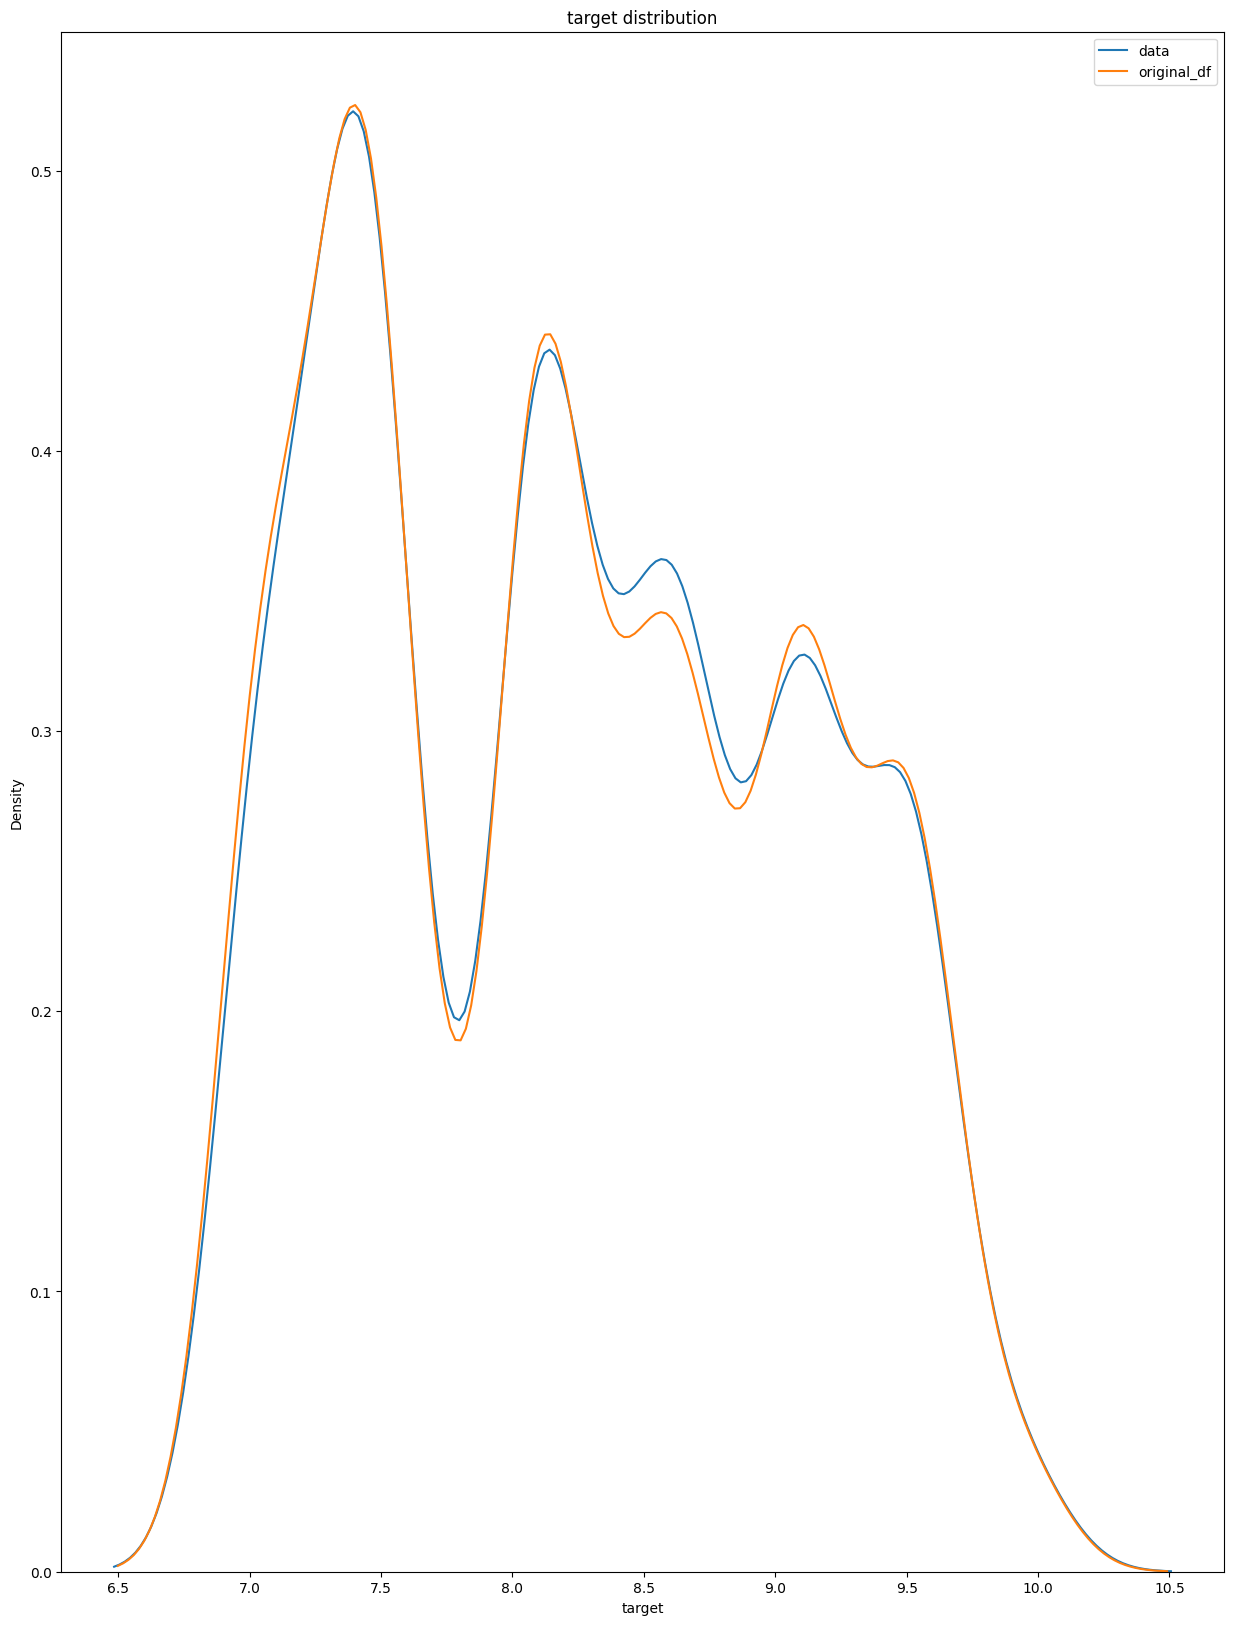

In [117]:
sns.kdeplot(data=submission[submission['target']<10], x="target")
sns.kdeplot(data=data[data['target']<10], x="target")
plt.legend(['data','original_df'])
plt.title('target distribution')

In [118]:
drop_index = np.random.choice(submission[submission['target']==8.6].index.to_numpy(), 10, replace=False)
submission = submission.drop(drop_index)


Text(0.5, 1.0, 'target distribution')

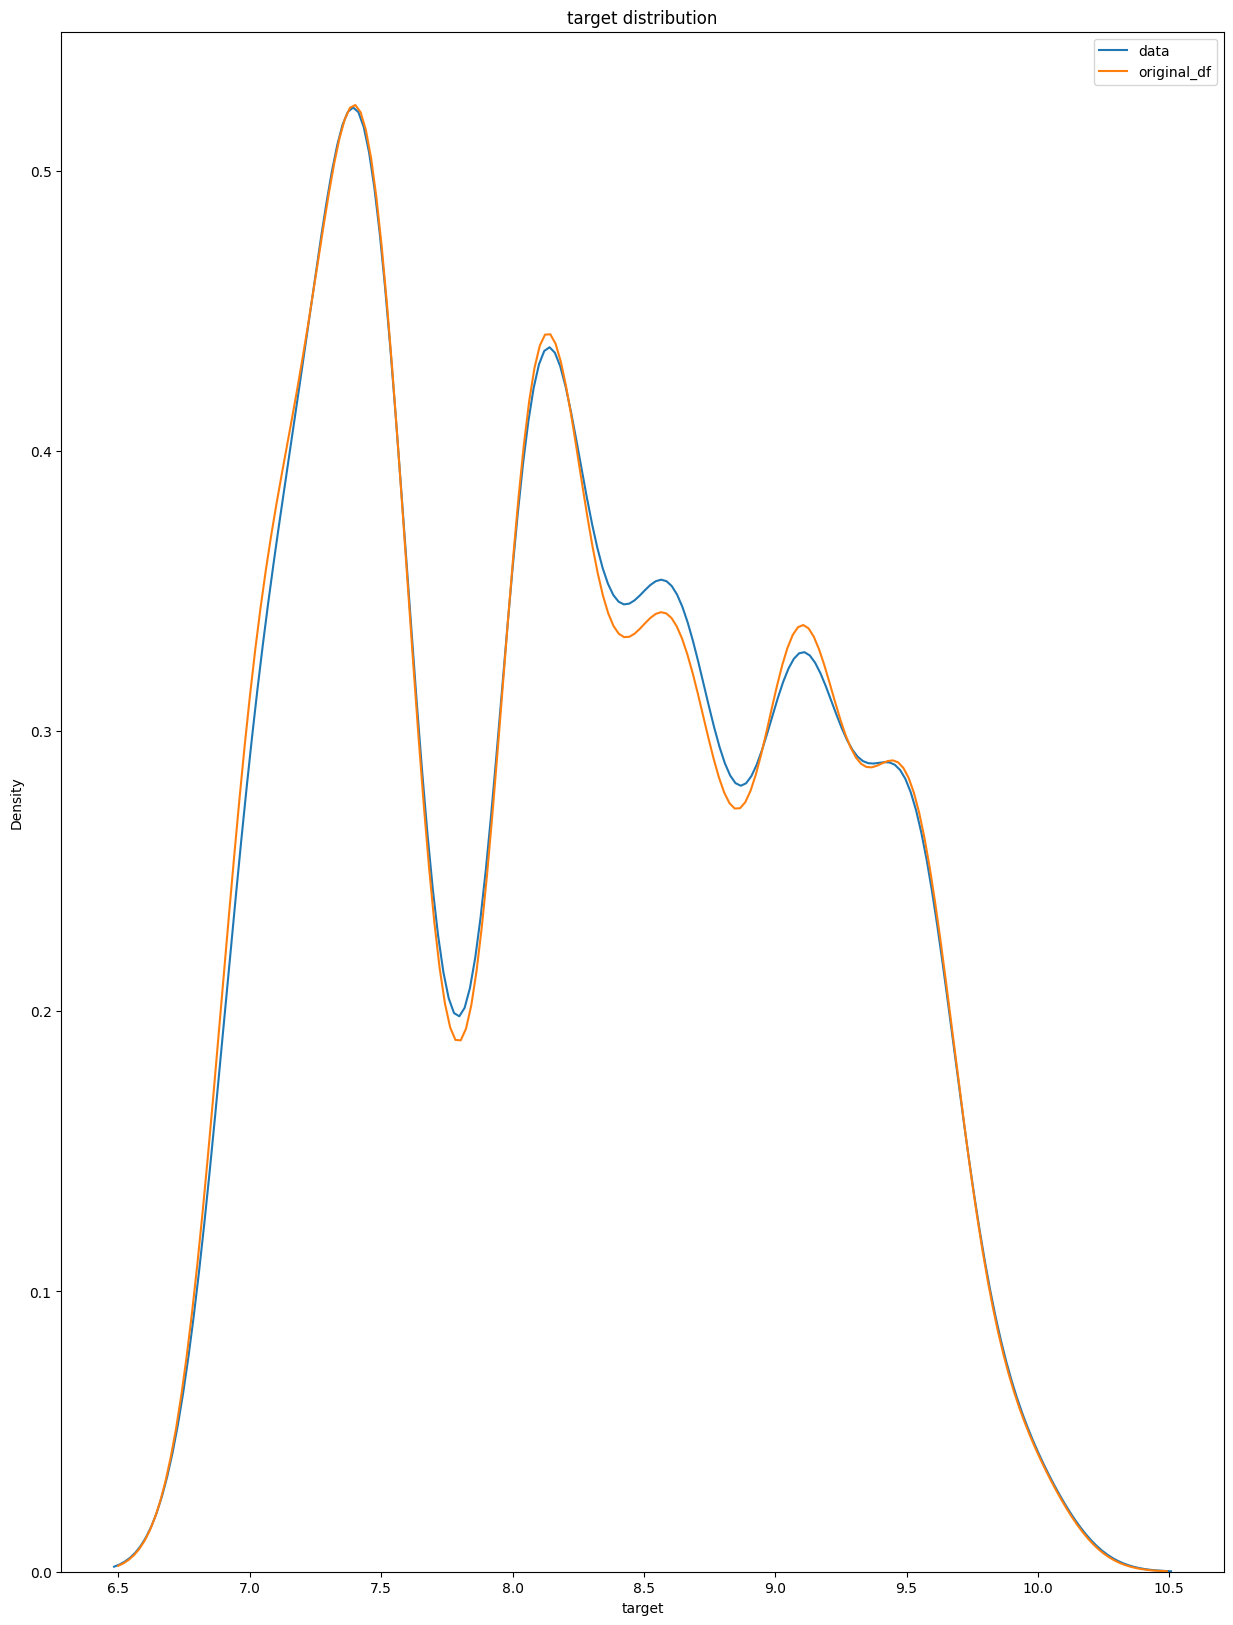

In [119]:
sns.kdeplot(data=submission[submission['target']<10], x="target")
sns.kdeplot(data=data[data['target']<10], x="target")
plt.legend(['data','original_df'])
plt.title('target distribution')

In [121]:
submission.to_csv('submission.csv', index = False)

In [120]:
submission

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,9.265,0,0,0,0.180,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,8.21,3.710,5.420,0,9.265,0,0,0,0.020,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
2,0,8.39,8.700,8.100,0,9.200,0,0,0,0.280,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
3,0,8.07,8.050,8.650,0,9.265,0,0,0,0.360,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
4,0,8.12,9.000,9.000,0,9.115,0,0,0,0.240,0,0,0,0,0.280,0,0,0.060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,0,8.65,8.367,8.760,0,9.265,0,0,0,0.720,0,0,0,0,0.280,0,0,0.040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2861,0,8.08,6.250,8.300,0,9.265,0,0,0,0.565,0,0,0,0,0.429,0,0,0.052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.695,0,0
2862,0,8.09,6.630,6.630,0,7.600,0,0,0,1.300,0,0,0,0,1.285,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2863,0,9.95,8.367,8.433,0,6.170,0,0,0,0.430,0,0,0,0,0.310,0,0,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
